In [25]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy
import matplotlib.pyplot as plt
from pathlib import Path
from numba.core import types
import graph_tool
import numba
import time 

from numba import njit
from graph_tool.topology import shortest_distance
import graph_tool as gt
import pandas as pd
import networkx as nx
import numpy as np
import typing
import matplotlib as mpl
import numba
from numba.core import types


# CUSTOM LIBS:
from read_data import get_network_df, get_corrs, get_full_df
from get_graph import get_graph_by_name
from transport_problem import OptimParams, DualOracle, HyperParams

from oracle_utils import AlgoResults
from subgd import OracleStacker, ustm_mincost_mcf

from sinkhorn import Sinkhorn
from sinkhorn_appendix import ustm_sinkhorn_mincost_mcf, OracleSinkhornStacker

from acrcd_no_adaptive import ACRCDOracleStacker, ACRCD_star


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
net_df, corrs = get_graph_by_name("Anaheim")
graph = gt.Graph(net_df.values, eprops=[('capacity', 'double'), ('fft', 'double')])

l = np.maximum(np.sum(corrs, axis=1), 1e-6)
w = np.maximum(np.sum(corrs, axis=0), 1e-6)

zones_num = len(l)
sources = np.arange(zones_num)
targets = np.arange(zones_num)

params = HyperParams(gamma=10, mu_pow=0.25, rho=0.15)

graph type:  Anaheim
3.579924242


In [3]:
oracle = DualOracle(graph, l, w, params, net_df=net_df)

ustm_stacker = OracleStacker(oracle, graph, sources, targets)
sinkhorn_stacker = OracleSinkhornStacker(oracle, graph, sources, targets, l, w, params)
acrcd_stacker = ACRCDOracleStacker(oracle, graph, sources, targets)

In [4]:
def calc_custom_metric(results, oracle_stacker):
    x = results.history_count_calls
    dual_gap = results.history_dual_gap
    dual_gap_clipped = np.maximum(0, dual_gap)
    la_mu_end_norm = np.linalg.norm(np.hstack([oracle_stacker.optim_params.la, oracle_stacker.optim_params.mu]))               
    metric = 2 * np.array(results.history_la_mu_grad_norm) * la_mu_end_norm + dual_gap_clipped
    return metric

In [5]:
def custom_plot(x, y, label=None, show=True, swap=False, log_x=False, log_y=True):
    if swap:
        x, y = y, x
    plt.plot(x, y, label=label)
    plt.legend()
    if log_x:
        plt.xscale("log")
    if log_y:
        plt.yscale("log")
    if show: plt.show()
        
    plot_to_csv(x, y, csv_name=label+".csv")
    return x, y

In [6]:
def plot_to_csv(x, y, csv_name):
    data = list(zip(x, y))
    if len(data) > 500:
        step = len(data) // 200
        data = [data[i] for i in range(0, len(data), step)]
    
    x, y = list(zip(*data))
    df = pd.DataFrame({"x":x, "y":y})
    df.columns.name
    df.to_csv(csv_name, index=False)

## Testing USTM

In [7]:
t_start = time.time()
ustm_results = ustm_mincost_mcf(ustm_stacker,  eps_abs=1e-4, crit_eps_abs=1e-2, 
                                eps_cons_abs=1e-4, max_iter=5000,  stop_by_crit=True)
print(f"total time taken: {time.time() - t_start}")

first exceeding the limits:  0.2626075155504874
start optimizing
first dual_func:  0.4185608483996006


 66%|██████▌   | 3282/5000 [00:51<00:26, 63.82it/s]

EARLY STOPPING
total time taken: 51.55173373222351


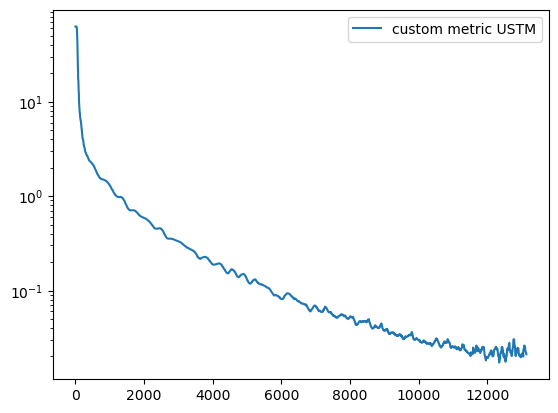

In [10]:
custom_metric_ustm = calc_custom_metric(ustm_results, ustm_stacker)
custom_plot(ustm_results.history_count_calls, custom_metric_ustm, label="custom metric USTM")
None

## Testing USTM + Sinkhorn

In [11]:
t_start = time.time()

t, sinkhorn_results_t, sinkhorn_results_inner = ustm_sinkhorn_mincost_mcf(sinkhorn_stacker,  eps_abs=1e-2, crit_eps_abs=1e-2, eps_cons_abs=1e-4,
                                                max_iter=100, stop_by_crit=True)
print(f"total time taken: {time.time() - t_start}")

52.24705881856717 1.5133372668436754e-06
start optimizing


 18%|█▊        | 18/100 [00:04<00:18,  4.40it/s]

STOP BY CRIT!!!
total time taken: 4.1415369510650635


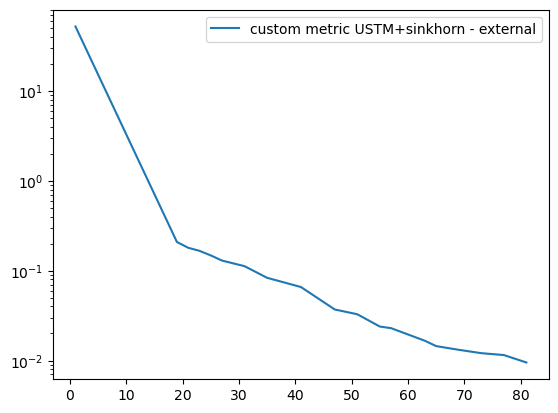

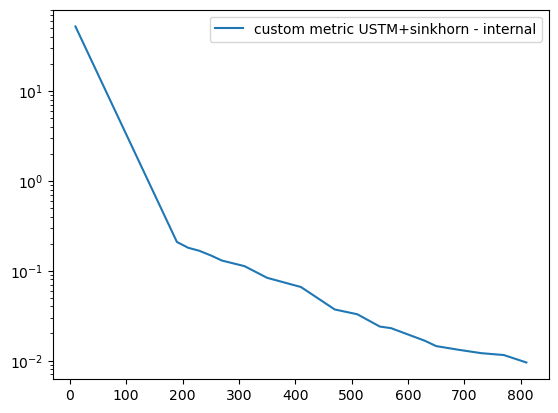

In [17]:
custom_metric_ustm_sinkhorn = calc_custom_metric(sinkhorn_results_t, sinkhorn_stacker)
custom_plot(sinkhorn_results_t.history_count_calls, custom_metric_ustm_sinkhorn, label="custom metric USTM+sinkhorn - external")
custom_plot(sinkhorn_results_inner.history_count_calls, custom_metric_ustm_sinkhorn, label="custom metric USTM+sinkhorn - internal")
None

## ACRCD

In [18]:
t_start = time.time()
acrcd_results_t, acrcd_results_la_mu = ACRCD_star(acrcd_stacker, *acrcd_stacker.get_init_vars_block(), 
                                                  K=5000, L1_init=0.5, L2_init=3e-2)
print(f"total time taken: {time.time() - t_start}")

  0%|          | 0/5000 [00:00<?, ?it/s]/home/jupyter/transport/transport_network_optimization/transport_problem.py:168: RuntimeWarning: divide by zero encountered in log
  return np.sum(self.sigma(f)) + self.params.gamma * np.sum(d * np.log(d))
/home/jupyter/transport/transport_network_optimization/transport_problem.py:168: RuntimeWarning: invalid value encountered in multiply
  return np.sum(self.sigma(f)) + self.params.gamma * np.sum(d * np.log(d))
100%|██████████| 5000/5000 [00:33<00:00, 149.84it/s]

total time taken: 33.37556529045105


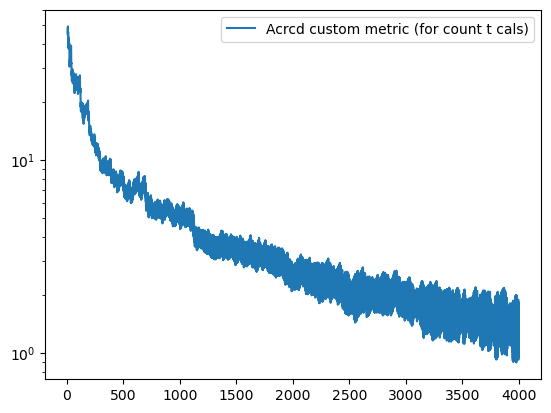

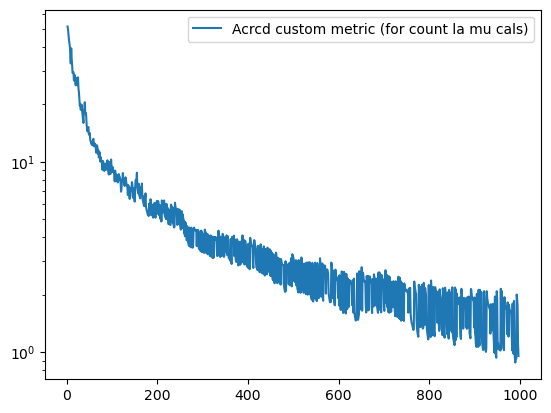

In [20]:

acrcd_custom_metric_t = calc_custom_metric(acrcd_results_t, acrcd_stacker)
custom_plot(acrcd_results_t.history_count_calls, acrcd_custom_metric_t, label="Acrcd custom metric (for count t cals)")

acrcd_custom_metric_la_mu = calc_custom_metric(acrcd_results_la_mu, acrcd_stacker, )
custom_plot(acrcd_results_la_mu.history_count_calls, acrcd_custom_metric_la_mu, label="Acrcd custom metric (for count la mu cals)")
None

## ИТОГОВОЕ СРАВНЕНИЕ + СОХРАНЕНИЕ ГРАФИКОВ

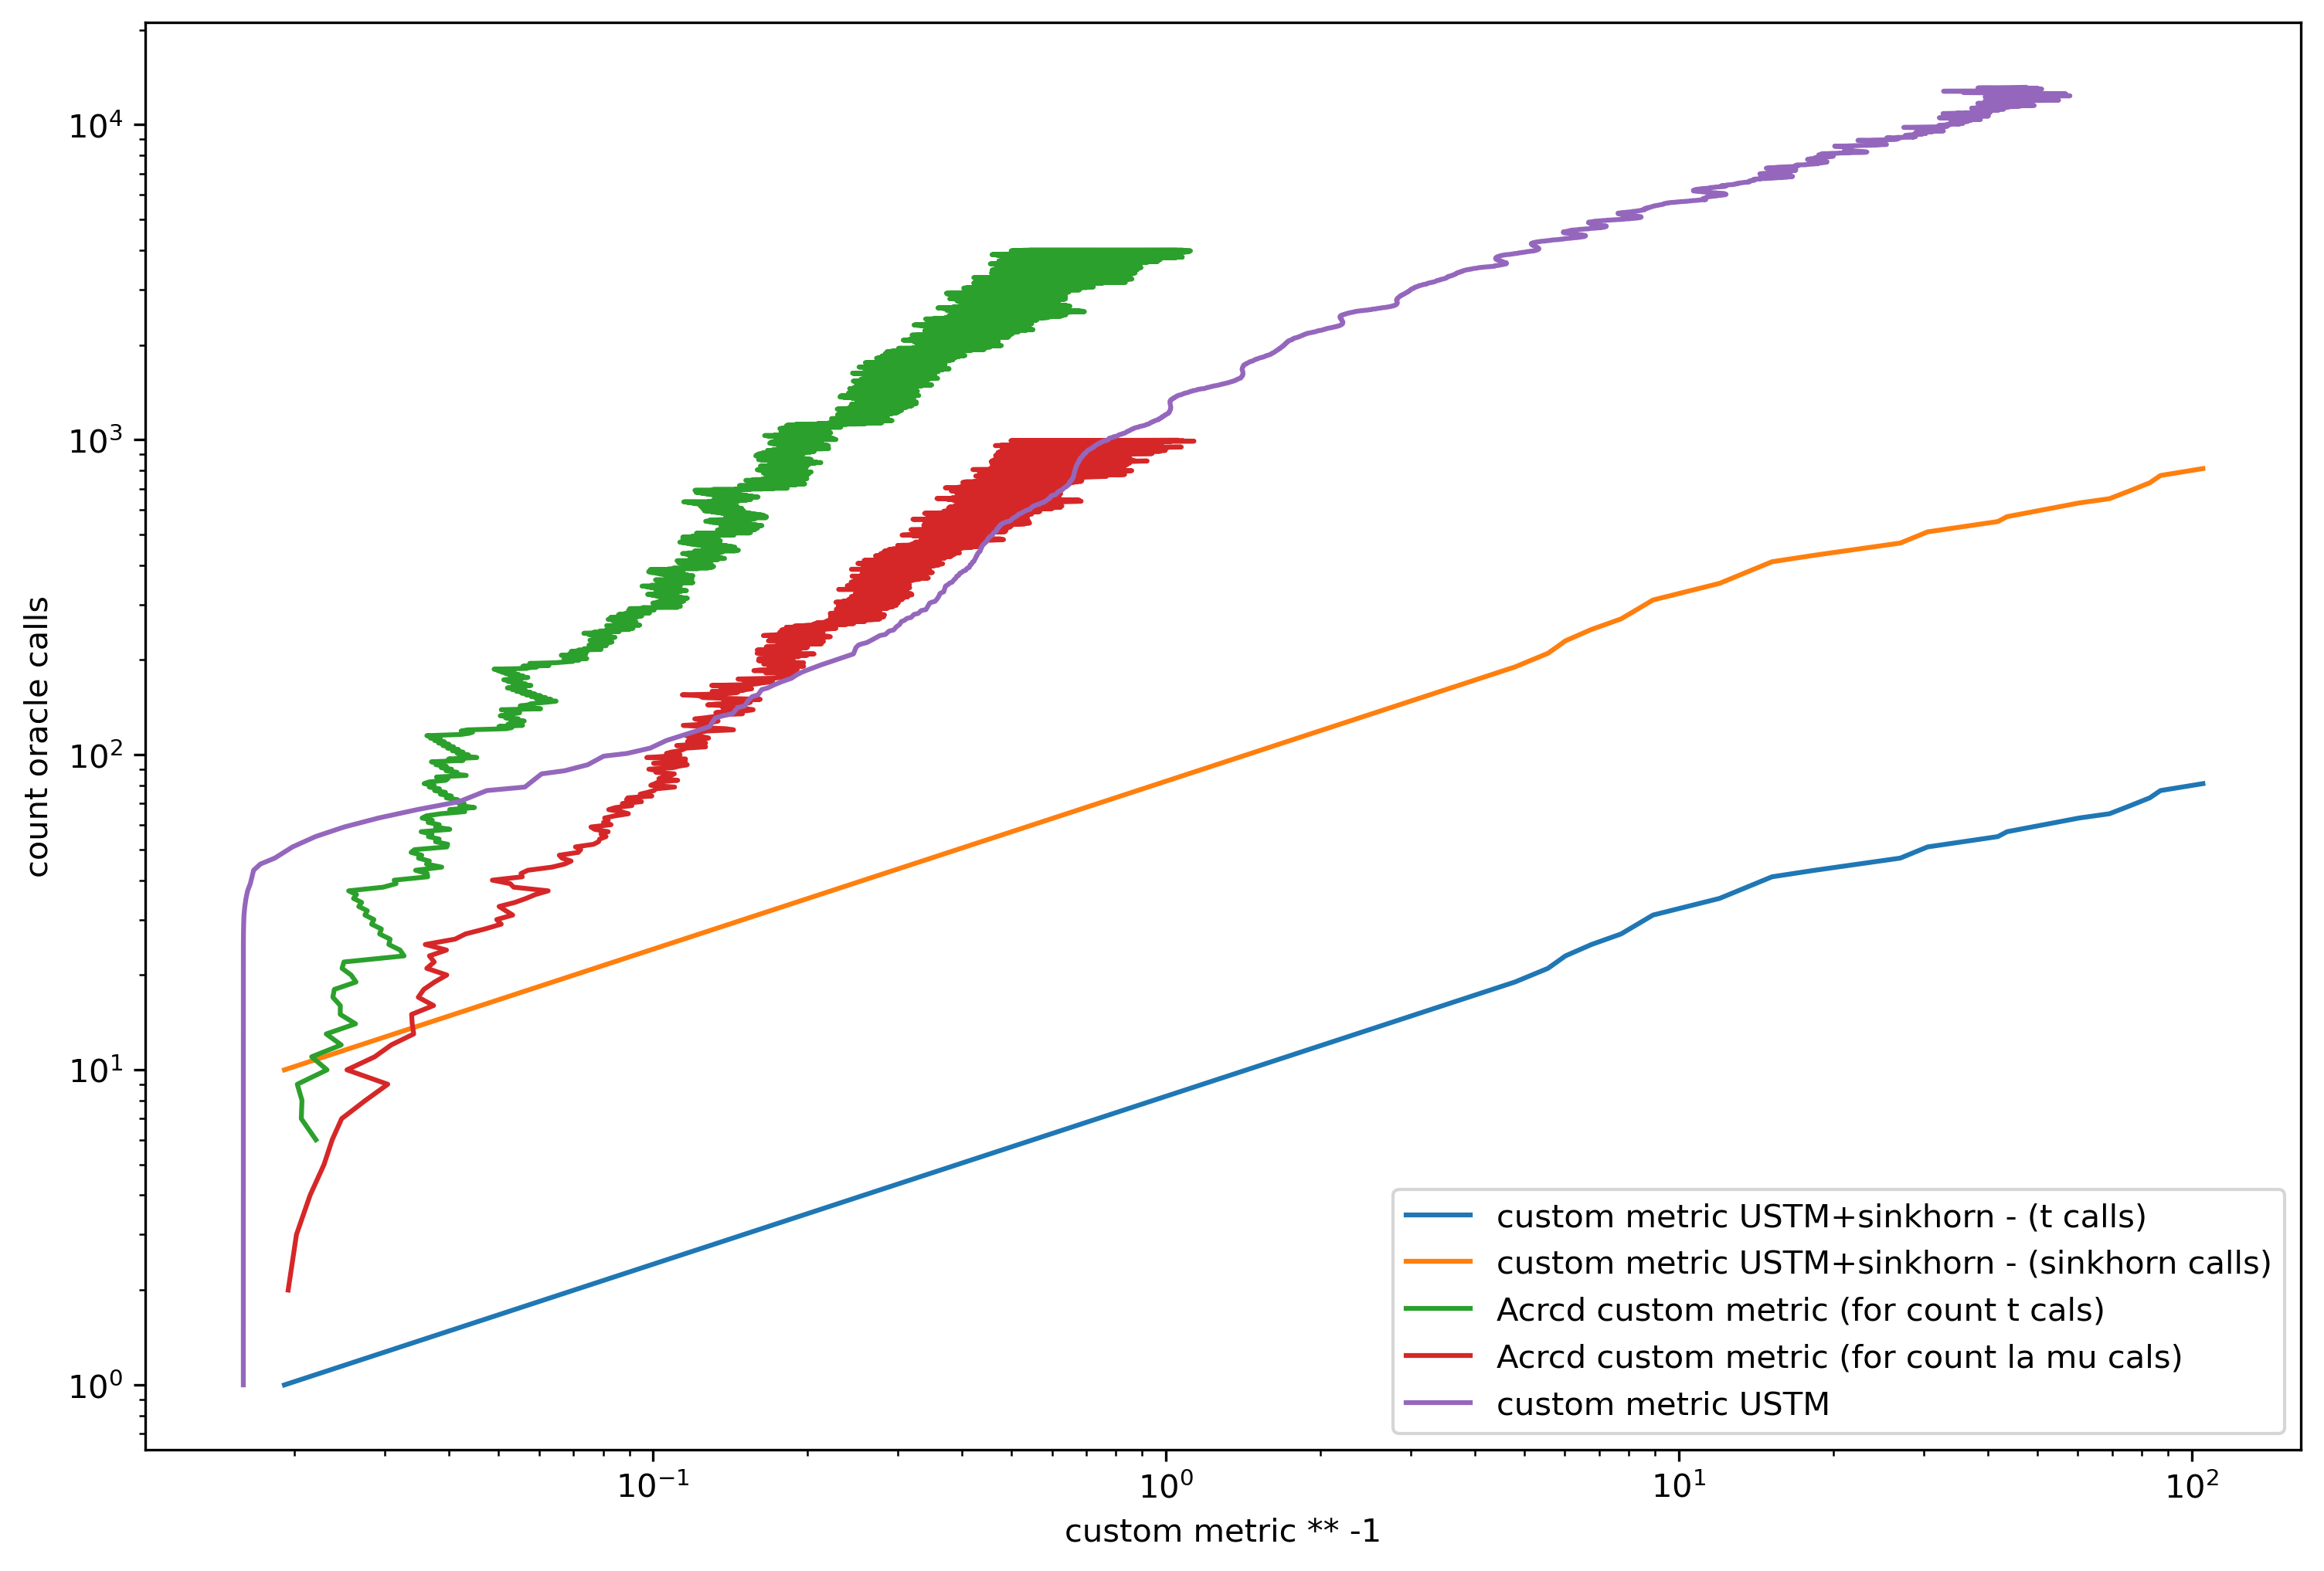

In [31]:
SWAP = True
LOG_X = True
LOG_Y = True
params_plot = dict(swap=True, log_x=True, log_y=True, show=False)

plt.figure(figsize=(12, 8))
plt.xlabel("custom metric ** -1")
plt.ylabel("count oracle calls")

common_data_for_csv = []

tmp = custom_plot(sinkhorn_results_t.history_count_calls, custom_metric_ustm_sinkhorn**-1, 
            label="custom metric USTM+sinkhorn - (t calls)", 
            **params_plot)

tmp = custom_plot(sinkhorn_results_inner.history_count_calls, custom_metric_ustm_sinkhorn**-1,
            label="custom metric USTM+sinkhorn - (sinkhorn calls)", 
            **params_plot)

tmp = custom_plot(acrcd_results_t.history_count_calls, acrcd_custom_metric_t**-1,
            label="Acrcd custom metric (for count t cals)", 
            **params_plot)

tmp = custom_plot(acrcd_results_la_mu.history_count_calls, acrcd_custom_metric_la_mu**-1,
            label="Acrcd custom metric (for count la mu cals)", 
            **params_plot)

tmp = custom_plot(ustm_results.history_count_calls, custom_metric_ustm**-1, 
            label="custom metric USTM",
            **params_plot)

plt.gcf().set_dpi(300)
plt.savefig("readme_images/comparison_plot.png")